### Todos
- look at torch lighting
- look at small ResNet (e.g. ResNet12)
- clean up code
- integrate weights and biases
- fly drone with xbox controller in simulation
- change drone video output to match input

tip: search parameters to see how others have used it

make everything parametric -> e.g. dictionary specifying cnn, then code does the rest

### Imports

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import numpy as np
import random
from os import PathLike
import copy
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from typing import List, Tuple
from tqdm.notebook import tqdm
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Dataloader

In [40]:
# Create dataloader
class DroneImagesDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = np.genfromtxt(csv_file, delimiter=',', dtype=None, encoding=None, skip_header=True)
        self.transform = transform

    def __getitem__(self, index):
        img_path = self.annotations[index][0]
        img_path = "all_images/" + img_path[11:] # when using ubuntu uncomment this line
        image = cv2.imread(img_path)
        left, forward, right = float(self.annotations[index][1]), float(self.annotations[index][2]), float(self.annotations[index][3])
        y_label = torch.tensor([left, forward, right])
        
        if self.transform:
            image = self.transform(image)

        return (image, y_label)
    
    def __len__(self):
        return len(self.annotations)

#### Transformer

In [41]:
# transform that makes it a tensor and crops the bottom third of the image
# to try: bilinear, bicubic or nearest exact
IMAGE_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((520, 120)),
    transforms.Grayscale(),
    transforms.Resize((130, 60), interpolation=transforms.InterpolationMode.NEAREST_EXACT),
])

#### Examples

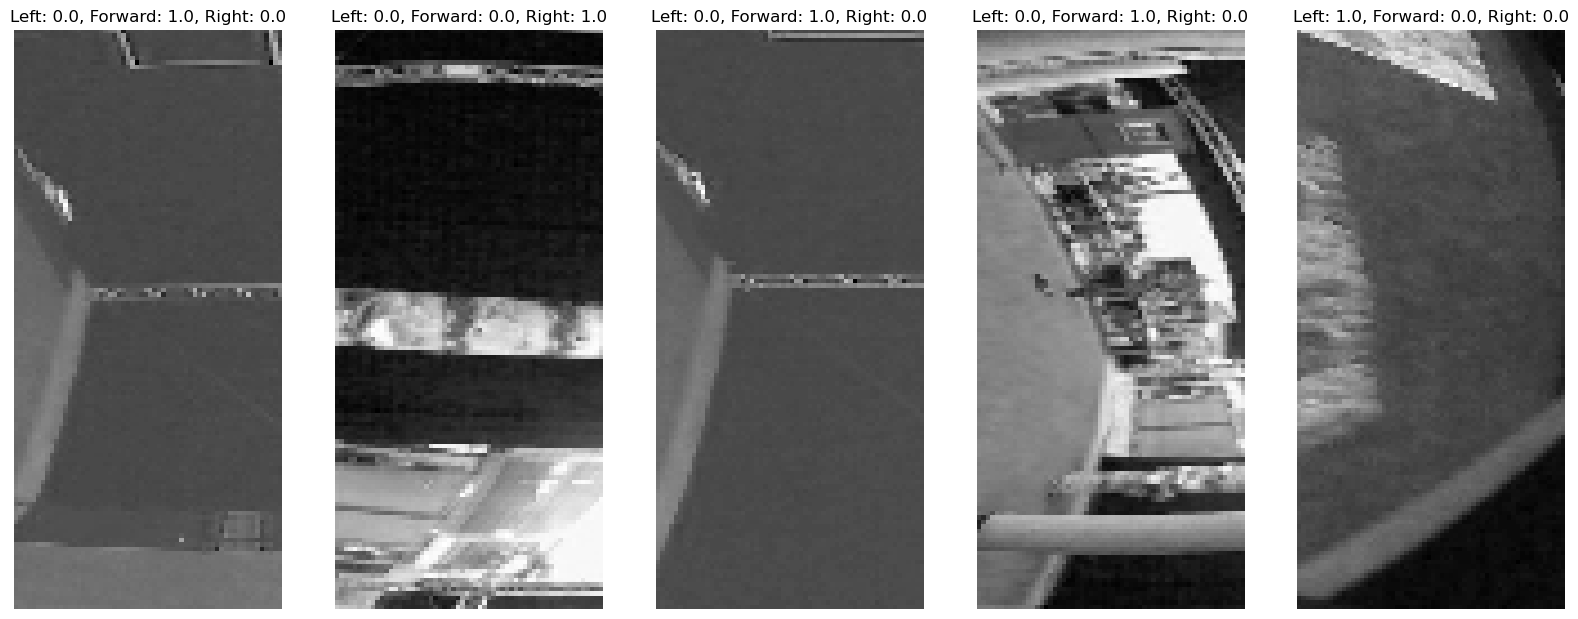

In [42]:
dataset = DroneImagesDataset('labeled_images.csv', transform=IMAGE_TRANSFORM)

# show 5 random grayscale images
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
for i in range(5):
    image, label = dataset[random.randint(0, len(dataset))]
    ax[i].imshow(image.squeeze(0), cmap='gray')
    ax[i].set_title(f'Left: {label[0]}, Forward: {label[1]}, Right: {label[2]}')
    ax[i].axis('off')

# Show how many samples we have for each label
show_labels = False
left = 0
forward = 0
right = 0

if show_labels:
    for i in range(len(dataset)):
        _, label = dataset[i]
        if label[0] == 1:
            left += 1
        elif label[1] == 1:
            forward += 1
        elif label[2] == 1:
            right += 1

    print(f'Left: {left}, Forward: {forward}, Right: {right}')

#### Train, Val, Test dataloaders

In [43]:
def dataloaders(
        dataset_path: PathLike = 'labeled_images.csv',
        val_ratio: float = 0.2,
        test_ratio: float = 0.1,
        batch_size: int = 32,
) -> Tuple[DataLoader, DataLoader, DataLoader]:
    """
    Create dataloaders for the training, validation, and test sets.

    Args:
        val_ratio: The ratio of the dataset to use for validation.
        test_ratio: The ratio of the dataset to use for testing.
        batch_size: The number of samples in each batch.

    Returns:
        A tuple of DataLoaders for the training, validation, and test sets.
    """

    dataset = DroneImagesDataset(csv_file=dataset_path, transform=IMAGE_TRANSFORM)

    # Split the dataset into training, validation, and test sets
    num_samples = len(dataset)
    num_val_samples = int(val_ratio * num_samples)
    num_test_samples = int(test_ratio * num_samples)
    num_train_samples = num_samples - num_val_samples - num_test_samples
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [num_train_samples, num_val_samples, num_test_samples]
    )

    # Create DataLoaders for the training, validation, and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, prefetch_factor=2, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, prefetch_factor=2, persistent_workers=True)

    return train_loader, val_loader, test_loader

# Create dataloaders
train_loader, val_loader, test_loader = dataloaders()

### Model

In [44]:
# Create a CNN
class CNN(nn.Sequential):
    def __init__(self):
        conv1 = nn.Conv2d(1, 6, kernel_size=(5,5), stride=1, padding=1)
        act1 = nn.ReLU()
        pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout1 = nn.Dropout(0.2)
        # batchnorm1 = nn.BatchNorm2d(6)
        # groupnorm1 = nn.GroupNorm(3, 6)
        # spatial_dropout1 = nn.Dropout2d(0.2) -> have a look

        conv2 = nn.Conv2d(6, 5, kernel_size=(5,5), stride=1, padding=1)
        act2 = nn.ReLU()
        pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout2 = nn.Dropout(0.1)
        # batchnorm2 = nn.BatchNorm2d(5)

        conv3 = nn.Conv2d(5, 5, kernel_size=(5,5), stride=1, padding=1)
        act3 = nn.ReLU()
        pool3 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        dropout3 = nn.Dropout(0.1)
        # batchnorm3 = nn.BatchNorm2d(5)

        flatten = nn.Flatten()

        fc1 = nn.Linear(350, 3)

        # TODO -> add batch normalization
        # rescale weights because of the dropout? -> no this is done when you call model.eval()

        super(CNN, self).__init__(
            conv1, act1, pool1, dropout1,# batchnorm1,
            conv2, act2, pool2, dropout2,# batchnorm2,
            conv3, act3, pool3, dropout3,# batchnorm3,
            flatten,
            fc1
        )

In [45]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def evaluate_model(model, loader):
    """
    Evaluate the model on the given dataset.

    Args:
        model: The model to evaluate.
        loader: The DataLoader for the dataset.

    Returns:
        The average loss and accuracy.
    """
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0.0
    correct = 0
    total = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            _, actual = torch.max(labels, 1)
            correct += (predicted == actual).sum().item()
            total += labels.size(0)
            
    return total_loss / len(loader), correct / total

In [49]:
early_stopper = EarlyStopper(patience=10, min_delta=0.01)

# Train the model
def train_model(model, train_loader, val_loader, num_epochs, label_smoothing, learning_rate, momentum, logging):
    """
    Train the model.

    Args:
        model: The model to train.
        train_loader: The DataLoader for the training set.
        val_loader: The DataLoader for the validation set.
        num_epochs: The number of epochs to train for.

    Returns:
        The best model found during training.
    """
    loss_fn = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    best_model = None
    best_val_loss = float('inf')

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for i, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 50 == 49:
                print(f'Epoch {epoch + 1}, batch {i + 1}: loss {running_loss / 200}')
                running_loss = 0.0

        val_loss, val_acc = evaluate_model(model, val_loader)
        print(f'Epoch {epoch + 1}: val_loss {val_loss}, val_acc {val_acc}')
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)

        if logging:
            wandb.log({"val_acc": val_acc, "val_loss": val_loss})

        if early_stopper.early_stop(val_loss):
            print(f'Early stopping at epoch {epoch + 1}')
            break

    return best_model

In [50]:
# Create a new model and train it
model = CNN()
model.to(device)
summary(model, (1, 130, 60))

num_epochs = 100
label_smoothing = 0.1
learning_rate = 0.001
momentum = 0.9
logging = False

model_name = f"CNN-e{num_epochs}-ls{label_smoothing}-lr{learning_rate}-m{momentum}"

if logging:
    # Define script parameters for wandb
    wandb.init(
        # set the wandb project where this run will be logged
        project="MAV-CNN-Project",
        
        # track hyperparameters and run metadata
        config={
        "learning_rate": learning_rate,
        "architecture": "CNN",
        "epochs": num_epochs,
        "label_smoothing": label_smoothing,
        "momentum": momentum,
        }
    )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 6, 128, 58]             156
              ReLU-2           [-1, 6, 128, 58]               0
         MaxPool2d-3            [-1, 6, 64, 29]               0
           Dropout-4            [-1, 6, 64, 29]               0
            Conv2d-5            [-1, 5, 62, 27]             755
              ReLU-6            [-1, 5, 62, 27]               0
         MaxPool2d-7            [-1, 5, 31, 13]               0
           Dropout-8            [-1, 5, 31, 13]               0
            Conv2d-9            [-1, 5, 29, 11]             630
             ReLU-10            [-1, 5, 29, 11]               0
        MaxPool2d-11             [-1, 5, 14, 5]               0
          Dropout-12             [-1, 5, 14, 5]               0
          Flatten-13                  [-1, 350]               0
           Linear-14                   

In [51]:
best_model = train_model(model, train_loader, val_loader, num_epochs, label_smoothing, learning_rate, momentum, logging)
if logging:
    wandb.finish()

# Evaluate the best model
test_loss, test_acc = evaluate_model(best_model, test_loader)
print(f'Test loss {test_loss}, test accuracy {test_acc}')

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1, batch 100: loss 0.5492537796497345
Epoch 1, batch 200: loss 0.549090935587883
Epoch 1: val_loss 1.0979215415318806, val_acc 0.33514644351464434
Test loss 1.0979283859855251, test accuracy 0.33807531380753136


In [31]:
# save model
torch.save(best_model.state_dict(), f'models/{model_name}.pth')

# save onnx
dummy_input = torch.randn(1, 1, 130, 60)
torch.onnx.export(best_model, dummy_input, f'models/{model_name}-test.onnx')

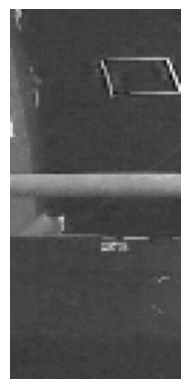

Predicted: tensor([-0.3419, -0.7506,  0.2365]), actual: tensor([0., 0., 1.])


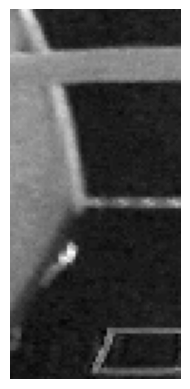

Predicted: tensor([-0.6896,  0.9232, -0.7617]), actual: tensor([0., 1., 0.])


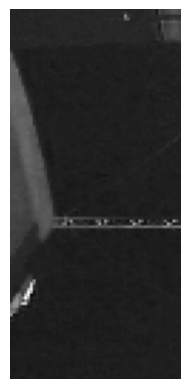

Predicted: tensor([-1.1534,  1.3233, -0.1013]), actual: tensor([0., 1., 0.])


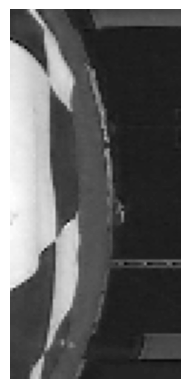

Predicted: tensor([ 0.1447,  0.6470, -2.0531]), actual: tensor([1., 0., 0.])


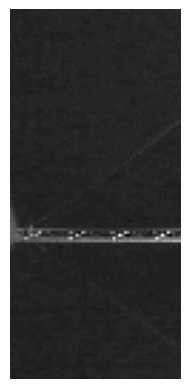

Predicted: tensor([ 0.0956,  0.0823, -0.1986]), actual: tensor([0., 0., 1.])


In [68]:
# Show test images together with the predicted and actual labels
def show_predictions(model, loader, num_images=5):
    """
    Show images together with the predicted and actual labels.

    Args:
        model: The model to use for prediction.
        loader: The DataLoader for the dataset.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            for j in range(inputs.size(0)):
                img = inputs[j].permute(1, 2, 0).cpu().numpy()
                plt.imshow(img, cmap='gray')
                plt.axis('off')
                plt.show()
                print(f'Predicted: {outputs[j]}, actual: {labels[j]}')
                num_images -= 1
                if num_images == 0:
                    return

show_predictions(best_model, test_loader)

In [69]:
import time
import os
# import torch
# import cv2
# import copy

best_model = CNN()
best_model.load_state_dict(torch.load('models/best_model_simple_1.pth'))
best_model.eval()

sequence_path = 'test_sequence'
sequence_path = 'wetransfer_drone_2024-03-08_1201/20240308-124634'

time_now = str(time.time()).replace('.', '')

# fourcc and video for mp4 vidoe of the sequence, frames are RBG (540x270x3)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output_'+time_now+'.avi',fourcc, 10, (520,240))

for filename in sorted(os.listdir(sequence_path)):
    img_path = os.path.join(sequence_path, filename)
    img = cv2.imread(img_path)

    img_trans = copy.deepcopy(img)
    img_trans = IMAGE_TRANSFORM(img_trans).unsqueeze(0)
    img_trans = img_trans.to(device)

    output = best_model(img_trans)

    # apply softmax to output
    output = F.softmax(output, dim=1)

    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    # create bar chart from output, then add to image in top right corner
    img = cv2.rectangle(img, (5,5), (85,55), (0, 0, 0), -1)
    img = cv2.rectangle(img, (10,50-int(output[0][0]*40)), (30,50), (255, 255, 255), -1)
    img = cv2.rectangle(img, (35,50-int(output[0][1]*40)), (55,50), (255, 255, 255), -1)
    img = cv2.rectangle(img, (60,50-int(output[0][2]*40)), (80,50), (255, 255, 255), -1)

    video.write(img)

# video.release()

RuntimeError: Error(s) in loading state_dict for CNN:
	Missing key(s) in state_dict: "4.running_mean", "4.running_var", "5.weight", "5.bias", "9.weight", "9.bias", "9.running_mean", "9.running_var", "10.weight", "10.bias", "14.weight", "14.bias", "14.running_mean", "14.running_var", "16.weight", "16.bias". 
	Unexpected key(s) in state_dict: "8.weight", "8.bias", "13.weight", "13.bias". 
	size mismatch for 4.weight: copying a param with shape torch.Size([5, 6, 5, 5]) from checkpoint, the shape in current model is torch.Size([6]).
	size mismatch for 4.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([6]).

[-0.212679   -0.07931083 -0.45897156 -0.4096589   0.18151873 -0.4910431 ]
[-0.08220396 -0.08490704  0.2552133  -0.20568725  0.16270329]


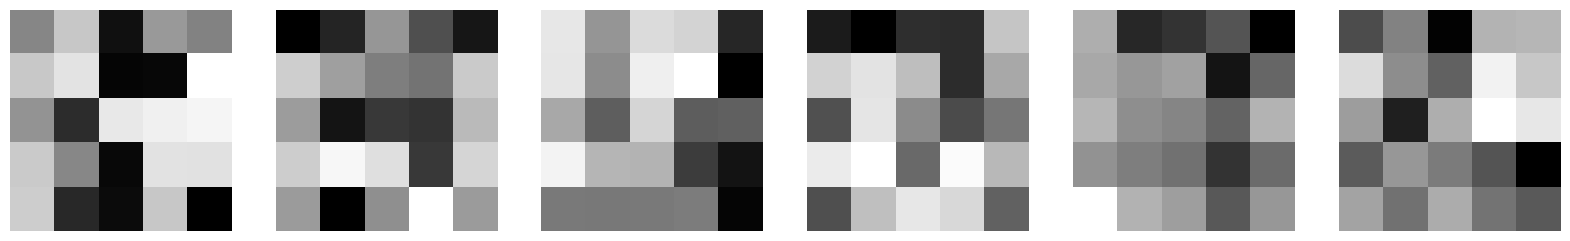

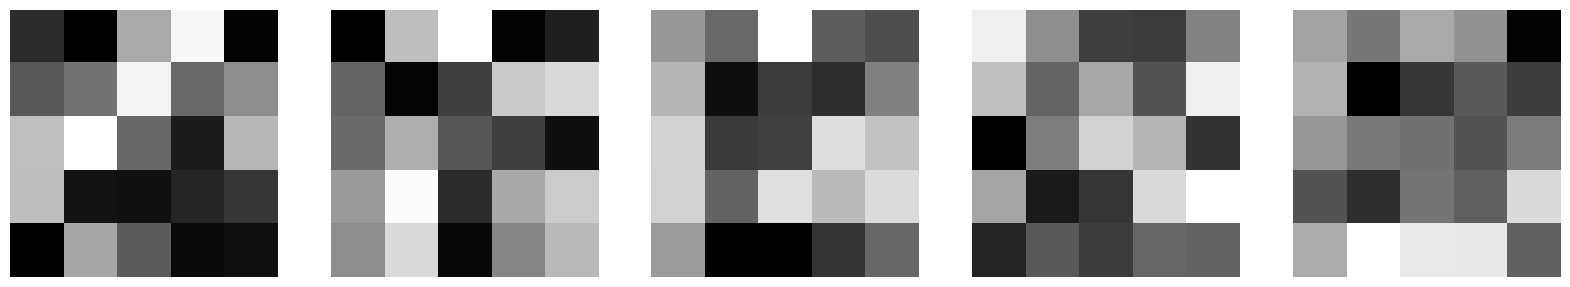

In [ ]:
best_model = CNN()
best_model.load_state_dict(torch.load('models/best_model_simple_1.pth'))
best_model.eval()

# show the the weights of the first layer
def show_weights(model):
    """
    Show the weights of the first layer of the model.

    Args:
        model: The model to show the weights of.
    """
    weights = model[0].weight.data.cpu().numpy()
    fig, ax = plt.subplots(1, weights.shape[0], figsize=(20, 10))
    for i in range(weights.shape[0]):
        ax[i].imshow(weights[i, 0], cmap='gray')
        ax[i].axis('off')

show_weights(best_model)

# show the biases of the first layer, no image, just the values
def show_biases(model):
    """
    Show the biases of the first layer of the model.

    Args:
        model: The model to show the biases of.
    """
    biases = model[0].bias.data.cpu().numpy()
    print(biases)

show_biases(best_model)

# show the weights of the second layer
def show_weights(model):
    """
    Show the weights of the second layer of the model.

    Args:
        model: The model to show the weights of.
    """
    weights = model[4].weight.data.cpu().numpy()
    fig, ax = plt.subplots(1, weights.shape[0], figsize=(20, 10))
    for i in range(weights.shape[0]):
        ax[i].imshow(weights[i, 0], cmap='gray')
        ax[i].axis('off')

show_weights(best_model)

# show the biases of the second layer, no image, just the values
def show_biases(model):
    """
    Show the biases of the second layer of the model.

    Args:
        model: The model to show the biases of.
    """
    biases = model[4].bias.data.cpu().numpy()
    print(biases)

show_biases(best_model)

In [ ]:
print(model[4])

# save model to binary .bin file
torch.save(best_model, 'models/best_model_simple_1.bin')

Conv2d(6, 5, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))


In [ ]:
import pickle

with open('models/best_model_simple_1.bin', 'rb') as f:
    obj = pickle.load(f, encoding='latin1')
    print(obj)

UnpicklingError: A load persistent id instruction was encountered,
but no persistent_load function was specified.

In [4]:
lin1 = nn.Linear(4, 3)

a = torch.randn(5, 7, 7, 8, 4)

out = lin1(a)
print(out.shape)

torch.Size([6, 4, 3, 3])


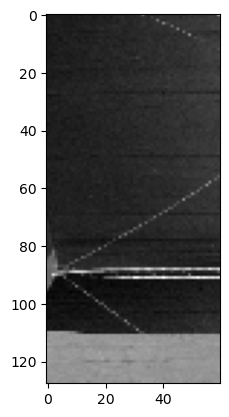

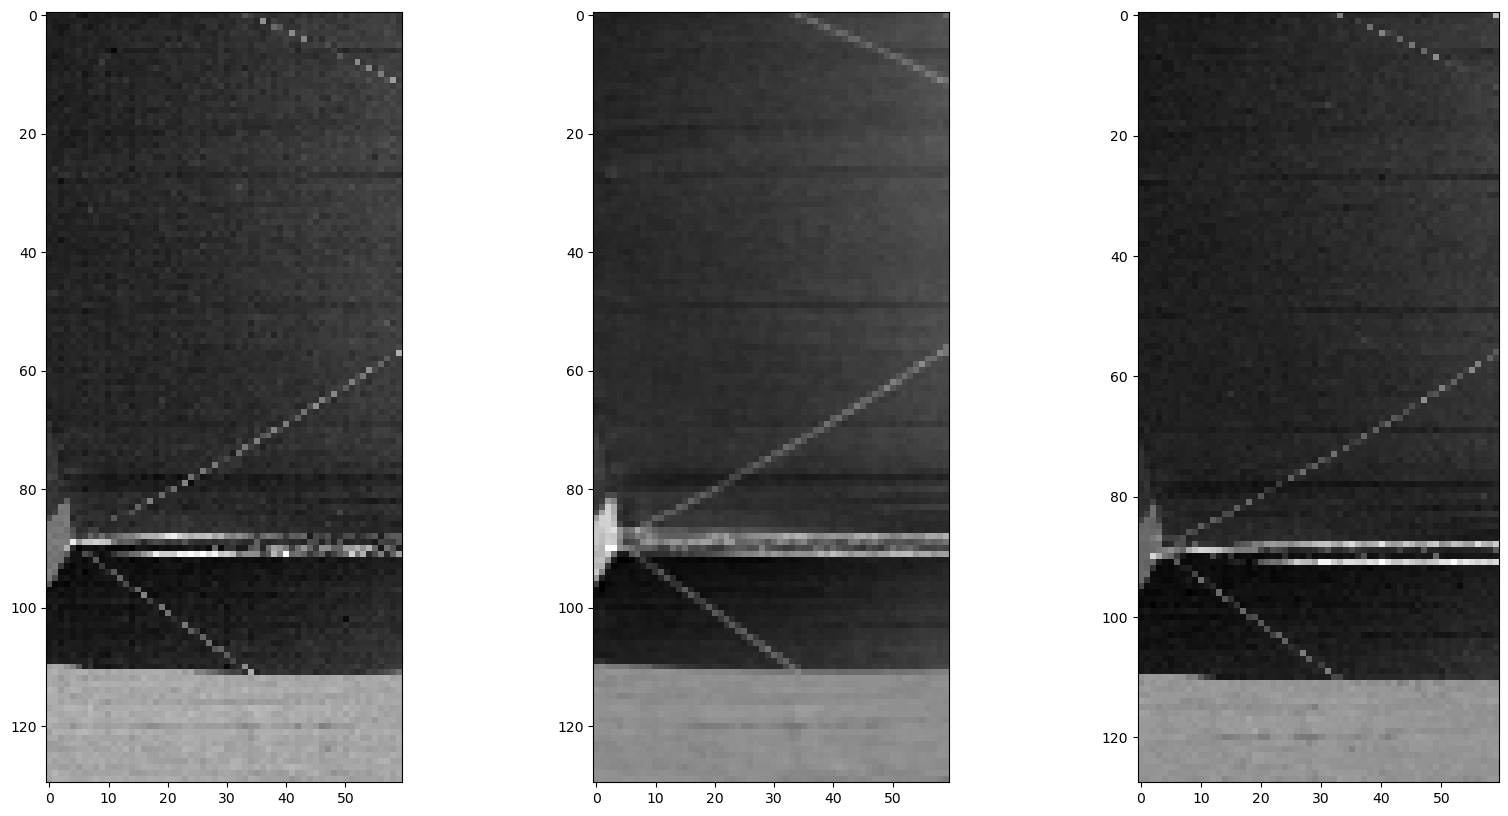

In [29]:
# image = 'images/11549407.jpg'
# image = 'images/43448467.jpg'
image = '16611000.jpg'

# read file
with open('test_tensor.txt', 'r') as f:
    lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = [line.split(' ') for line in lines]
    lines = [[float(x) for x in line] for line in lines]
    # print length of all the separete lines
    # print(len(lines))
    # for line in lines:
    #     print(len(line))
    # make all values above 255 to 255

# convert to array and show as image
lines = lines[:-1]
img_sim = np.array(lines)

img = cv2.imread(image)
# convert to yuv
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
# img_gray = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2GRAY_YUY2)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_gray = img_gray / 255

# crop top and bottom 25%, scale down with by 4 and height by 2
# original image is 520x240
img_self1 = np.zeros((130, 60))
img_self2 = np.zeros((130, 60))
for i in range(130):
    for j in range(60):
        img_self1[i, j] = img_gray[i*4:i*4+4, 60+j*2:60+j*2+2].mean()
        img_self2[i, j] = img_gray[i*4, 60+j*2]

IMAGE_TRANSFORM2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((520, 120)),
    transforms.Grayscale(),
    transforms.Resize((130, 60), interpolation=transforms.InterpolationMode.BICUBIC),
])

# Now with the image transform
img_trans = cv2.imread(image)
img_trans = IMAGE_TRANSFORM2(img_trans)

# Show the img_self and img_trans side by side
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
ax[0].imshow(img_self2, cmap='gray')
# ax[1].imshow(img_self2, cmap='gray')
ax[1].imshow(img_trans.squeeze(0), cmap='gray')
# ax[0].imshow(img_trans.squeeze(0), cmap='gray')
ax[2].imshow(img_sim, cmap='gray')


# # Check if they are the same
# print(np.allclose(img_sim, img_trans.squeeze(0).numpy(), 0.3))